# Predicting Cancerous Tumors from Histopathologic Cancer Dataset using CNN

## Introduction

This project is a binary image classification problem where the goal is to identify metastatic cancer in small image patches from larger digital pathology scans. We are provided with a large number of pathology images for classification that has an image id and labels with 0 meaning non-cancerous tumor tissue and 1 being cancerous tumor tissue. A postive label (1) indicates that there is at least a pixel of tumor tissue in the center of the 32x32 region. The dataset consists of a training data file with ground truth labels as well as the images in the training folder and testing folder for making predictions. An example submission file is also provided.

Furthur dataset description can be found in the Kaggle competition page https://www.kaggle.com/competitions/histopathologic-cancer-detection/data.

### The notebook is structured as follows:
1. Setting Up Environment

   Import modules such as sklearn and tensorflow for our project. We will be using the computer's GPU for training.
   
2. Exploratory Data Analysis (EDA)
   
   View summary statistics of training data and images data. Data cleaning and balance dataset as necessary.
   
3. Data Preprocessing
   
   Image normalization, and image Augmentation, including scaling values from 0 to 1, rotating, zooming, anf flipping the images to diversify training and
   validation dataset
   
   Defining Training/Validation Sets
   
   Image generator to create 80% training and 20% validation sets
   
4. Build, Compile and Train Base Model Architecture
    
    Utilize basic model architecture (pre-hyperparameter tuning)

    Train model using Tensorflow Keras Convolutional Neural Network (CNN)
    
5. Base Model Evaluation
    
    Assessing loss and accuracy for our metrics of performance.
    
6. Hyperparameter tuning and building upon the Base Model
    
   Increasing the learning rate from 0.0001 to 0.001
   
   Increasing epochs and steps
   
   Increasing number of layers
   
   Adding normalization layer for training stability and improving training time
   
   Adding additional dropout layers for reducing overfitting
   
   Once hypearameters are truened to desired, model is compiled and trained

7. Tuned Model Evaluation
    
    Evaluate loss of train vs validation and accuracy score. 

8. Predict on Test dataset for submission
    
    Retrieve Kaggle score
    
9. Discussion/ Summary
    
    Reflect on the work, discuss results and what can be improved

Import libraries and modules needed for the project. Libraries include but not limited to packages for displaying and graphing data summaries and output, image data processing, model building and model evaluations.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from torchvision import transforms
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential##, load_model
from keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adagrad, Adam, Nadam

Create a base direcotry path so that reading files and folders from the directory is easier:

In [2]:
current_directory = os.getcwd()
##convert forward slashes to backslashes
work_dir = current_directory.replace('\\', '/')
##print("Working Base Directory:", work_dir)

Using Deep learning with Tensor will require intensive computational resources. Therefore, make decrease the time for our model training, we will mount GPU from my system.

In [38]:
##Suppress warnings
warnings.filterwarnings("ignore")
##Check avaiablibility og GPU
print("\nGPU Available:", tf.test.is_gpu_available())
##Check GPU device name
print(tf.test.gpu_device_name())
##Check CUDA Toolkit and cuDNN installation
print("\nCUDA Toolkit Version:", tf.test.is_built_with_cuda())
##Check tensorflow version. This version should have GPU capbilityCheck TensorFlow installation
print("\nInstalled TensorFlow Version:", tf.__version__)


GPU Available: True
/device:GPU:0

CUDA Toolkit Version: True

Installed TensorFlow Version: 2.10.1


In [4]:
##Set and use the GPU
GPU = tf.config.experimental.list_physical_devices('GPU')
if GPU:
    tf.config.experimental.set_visible_devices(GPU[0], 'GPU')
    tf.config.experimental.set_memory_growth(GPU[0], True)
    print("GPU will be used.")
else:
    print("No GPU mounted, using CPU...")

GPU will be used.


In [5]:
all_df= pd.read_csv(work_dir+"/Documents/MS DS coursework/Intro to Deep Learning/Week 3/train_labels.csv")
all_df.head(7)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1


## Exploratory Data Analysis

Next we'll explore the data set. We'll example the counts than vidualize the negative (0) and postive (1) counts.

In [6]:
labels_count = all_df.label.value_counts()
labels_count

label
0    130908
1     89117
Name: count, dtype: int64

0 indicates no cancerous tumor detected (negatives) and 1 indicates cancerous tumor (positives).

[Text(0, 0, 'Negatives'), Text(1, 0, 'Positives')]

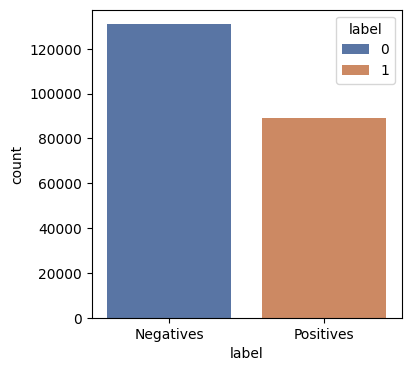

In [7]:
plt.figure(figsize=(4, 4))
neg_pos_plot = sns.countplot(x='label', hue='label', data=all_df, palette="deep")
neg_pos_plot.set_xticks([0, 1])
neg_pos_plot.set_xticklabels(['Negatives','Positives'])


We can see here that the data is not balanaced between 0 and 1's. Since this is a binary classification task, it's best that we balance the dataset before traning ans making predictions. This helps us to reduce bias from the majority class outweighting (which will give a false high accuracy) and can also help improve the generalization of a model to predicting unseen data. Balancing the data also helps to improve stability as quickness of convergenece during training.

For balancing, we will us as much of the data as possible so we'll balance so each catagory is at least 89,117 counts.

[Text(0, 0, 'Negatives'), Text(1, 0, 'Positives')]

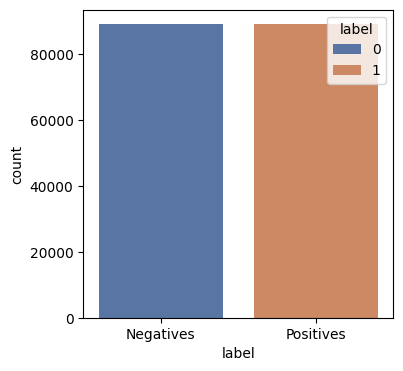

In [8]:
##Set random state
rs= 1234
##lowest count for postive values. 
##use at much of the data as possible to balance the training dataset
samp_size= 89117 

train_neg= all_df[all_df['label']==0].sample(samp_size, random_state=rs)
train_pos= all_df[all_df['label']==1].sample(samp_size, random_state=rs)

concat_dat= pd.concat([train_neg, train_pos], axis= 0).reset_index(drop=True)
new_train= shuffle(concat_dat)

plt.figure(figsize=(4, 4))
newtrain_plot = sns.countplot(x='label', hue='label', data=new_train, palette="deep")
newtrain_plot.set_xticks([0, 1])
newtrain_plot.set_xticklabels(['Negatives','Positives'])


In [9]:
labnew_count = new_train.label.value_counts()
labnew_count

label
1    89117
0    89117
Name: count, dtype: int64

In [10]:
def display_images(folder_path, num_imgs=9, row_img= 3, dat_type= "train"):
    ##get imgs from folder
    imgs = os.listdir(folder_path)
    ##randomly select imgs to display
    ##random_images = random.sample(imgs, min(num_imgs, len(imgs)))
    random_images= np.random.choice(imgs, num_imgs)
    ##iterate and show images with 0 or 1 labels
    ##fig, ax = plt.subplots(1, num_imgs, figsize=(20, 10))
    fig= plt.figure(figsize=(20, 10))
    if dat_type == "train":
        for i, img in enumerate(random_images):
            sp= fig.add_subplot(row_img, int(num_imgs/row_img), i+1)
            # image_path = os.path.join(folder_path+'/', img)
            image_path = Image.open(folder_path+'/'+img)
            plt.imshow(image_path)
            # img = Image.open(image_path)
            # ax[i].imshow(img)
            labels = all_df.loc[all_df["id"] == img.split('.')[0], 'label'].values[0]
            sp.set_title(f'Label: {labels}')
    else:
        for i, img in enumerate(random_images):
            sp= fig.add_subplot(row_img, int(num_imgs/row_img), i+1)
            image_path = Image.open(folder_path+'/'+img)
            plt.imshow(image_path)
        

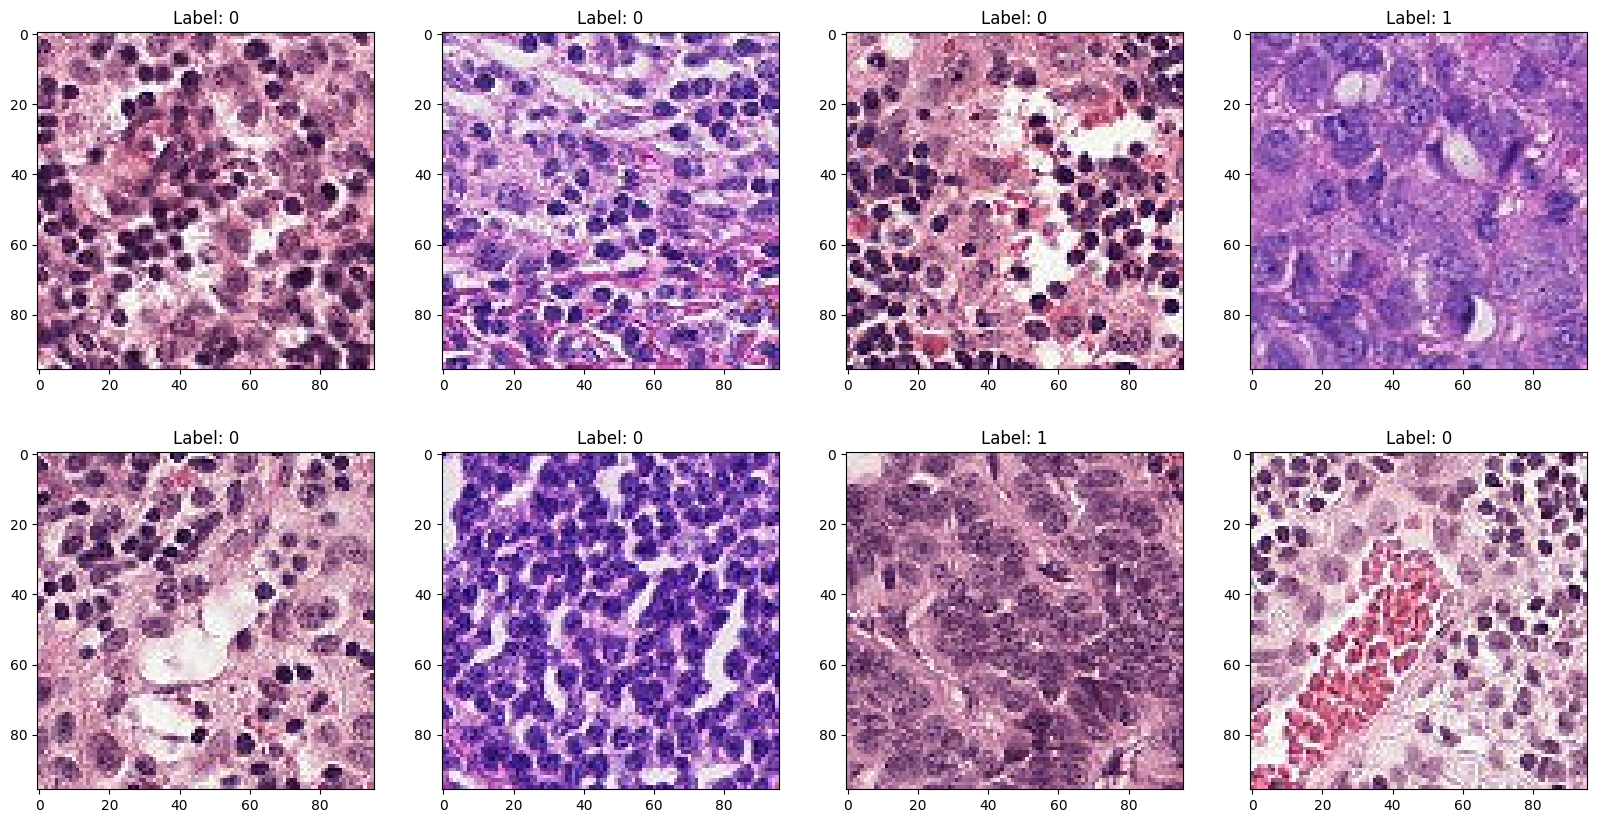

In [11]:
##Display 2x4 images randomly from the train folder
display_images(work_dir+"/Documents/MS DS coursework/Intro to Deep Learning/Week 3/train", num_imgs=8, row_img= 2, dat_type= "train")

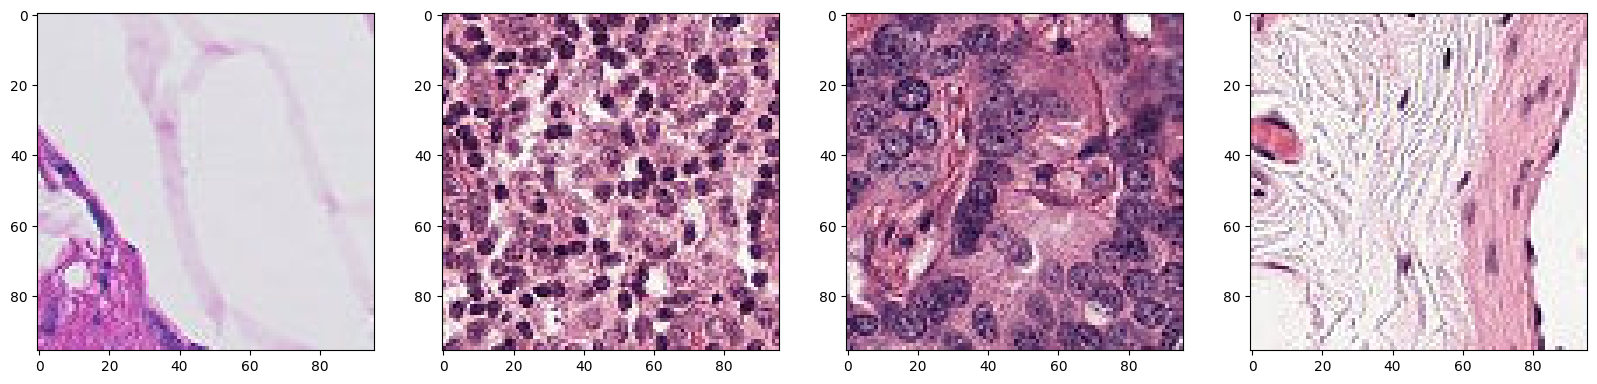

In [12]:
##Display 1x4 images randomly from the test folder
display_images(work_dir+"/Documents/MS DS coursework/Intro to Deep Learning/Week 3/test", num_imgs=4, row_img= 1, dat_type= "test")

Let's check the structure of the images to see what target size we'll be training on.

## Data Preprocessing

In the follow steps, we'll set the paths for the rest of the data to be used in data generation.

View the number of training and test images

In [13]:
impex= work_dir+"/Documents/MS DS coursework/Intro to Deep Learning/Week 3/train/00a092799b526521cdf35aab8ee306041f466f7a.tif"
imgarr = np.array(Image.open(impex))
print("Image shape:", imgarr.shape)

Image shape: (96, 96, 3)


In [14]:
train_imgs = len(os.listdir(work_dir+ "/Documents/MS DS coursework/Intro to Deep Learning/Week 3/train/"))
test_imgs = len(os.listdir(work_dir+ "/Documents/MS DS coursework/Intro to Deep Learning/Week 3/test/"))

print("Number of training imgs:", train_imgs)
print("Number of test imgs:", test_imgs)

Number of training imgs: 220025
Number of test imgs: 57458


In [15]:
##Read the rest of needed data training and test
train_path = work_dir+ "/Documents/MS DS coursework/Intro to Deep Learning/Week 3/train/"
##Read test images path
test_path = work_dir+ "/Documents/MS DS coursework/Intro to Deep Learning/Week 3/test/"
##Read sumission csv file
sample_sub= pd.read_csv(work_dir+"/Documents/MS DS coursework/Intro to Deep Learning/Week 3/sample_submission.csv")

In [16]:
##Balanced training data needs to be converted. Add in tif for string name because images have that
##convert labels to type str
all_df= new_train
all_df['id'] = all_df['id'] + '.tif'
all_df['label'] = all_df['label'].astype(str)
all_df.label.value_counts()
##View it ^

label
1    89117
0    89117
Name: count, dtype: int64

In [17]:
##Get training and dataset split
# train, valid = train_test_split(all_df, test_size=0.2)

##Using Image data generation to normalize augment image data randomly and get more diversified data
train_datagen =  ImageDataGenerator(rescale=1./255.,
                                    # rotation_range=30,
                                    # width_shift_range=0.1,
                                    # height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1,
                                    # channel_shift_range=0.1,
                                    horizontal_flip=True,
                                    # vertical_flip=True,
                                    validation_split=0.2)
##test_datagen =  ImageDataGenerator(rescale=1./255.,validation_split=0.2)

Now lets view and compare the original images and transformed images to see what the transforming and augmenting the images actually does. We'll using the torchvision module transforms for that.

In [18]:
##Define tehe transformation
##Convert the PIL Image to a PyTorch Tensor
##Example normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=25),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])  
])

##Image paths
imp= work_dir+"/Documents/MS DS coursework/Intro to Deep Learning/Week 3/train/000b666f7b5f03e81937cb12b3a1c8c279b08292.tif"
imp2= work_dir+"/Documents/MS DS coursework/Intro to Deep Learning/Week 3/train/000a2a35668f04edebc0b06d5d133ad90c93a044.tif"
image_path =imp
image_path2 =imp2

image = Image.open(image_path)
image2 = Image.open(image_path2)

##transform the images
transformed_image = transform(image)
transformed_image2 = transform(image2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Transformed Image 2')

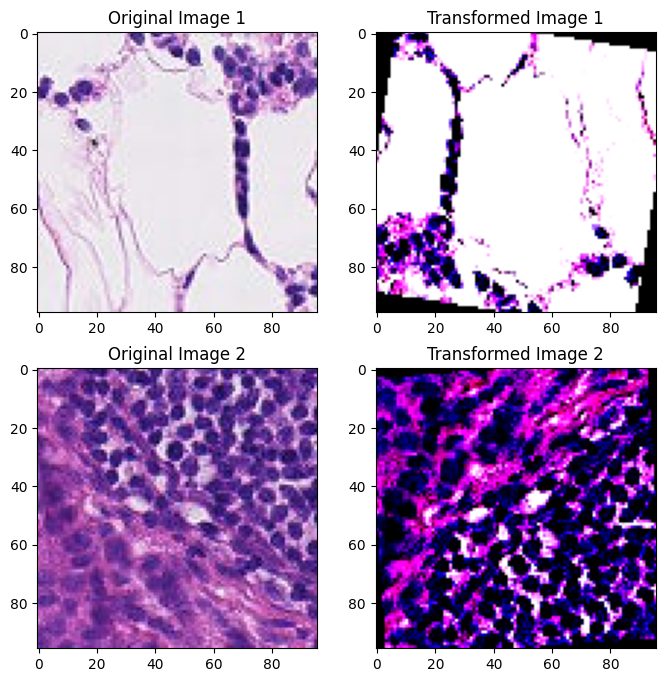

In [19]:
##show tranformed images versus the orginal images
fig, ax= plt.subplots(2,2, figsize=(8,8))

ax[0, 0].imshow(image)
ax[0, 0].set_title('Original Image 1')

ax[0, 1].imshow(np.transpose(transformed_image, (1,2,0)))
ax[0, 1].set_title('Transformed Image 1')

ax[1, 0].imshow(image2)
ax[1, 0].set_title('Original Image 2')

ax[1, 1].imshow(np.transpose(transformed_image2, (1,2,0)))
ax[1, 1].set_title('Transformed Image 2')
# plt.show()

We will be training our model using data generators. This step is important because actual image data may different in size shape, color, etc. so our model architecture may likely generalize better at predicted real-world unseen data.

In [20]:
rs = 123
batches = 32 ##, 64, 128, 246
##Due to computation resources, using 64x 64 and not 96x 96
target= (96,96)

##Set up data generators for images
train_gen = train_datagen.flow_from_dataframe(
    dataframe=all_df,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=batches,
    seed=rs,
    class_mode="binary",
    target_size=target)  

valid_gen = train_datagen.flow_from_dataframe(
    dataframe=all_df,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=batches,
    seed=rs,
    class_mode="binary",
    target_size=target) 

Found 142588 validated image filenames belonging to 2 classes.
Found 35646 validated image filenames belonging to 2 classes.


## Build, Compile and Train Base Model Architecture

Now we're ready to test a model architecture. We'll first begin with a convolutional neural network (CNN). CNNs work well to to capture spatial patterns and local relationships. We'll start with a convolutional layer of 32 filters and kernel size of (3,3) with relu activation and maxpool size of (2,2). We'll add another layer with filters 64 and another with 128 filters keeping other parameters being the same as the first layer to complete our convolutional network. As we add add these layers, increasing the number filters, we allow the model to learn more intricate patterns and features. We'll then end with a flattened dense output with 256 hidden nodes, a droput layer to reduce overfitting and improve network generalization and end it with 1 output node. We'll compile the model with the Adam optimizer, a stochastic gradient descent method based on adaptive estimation of first-order and second-order moments. It is an optimizer that is efficient (converges faster than other optimizers), have adaptable learning rates and low memory requirements which is an ideal option to use for our model.

In [21]:
##Our Model architecture
##Convolutional layers
model = models.Sequential()

# model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'), input_shape= (96, 96, 3)))
# model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape= (96, 96, 3)))
# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
# model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
# model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

##fully connected layers
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

##model compilation
##store different optimizers. Use for for project
# optimizers = SGD(learning_rate=0.01)
# optimizers = Nadam(learning_rate=0.0001)
optimizers = Adam(learning_rate=0.0001)
# optimizers = Adagrad(learning_rate=0.001)
model.compile(optimizer=optimizers, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
##build model
# model.build(input_shape=(batches, 96, 96, 3))
##View model summmary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

In [22]:
##Include callbacks for model fit
early_stop1 = EarlyStopping(monitor='val_loss', 
                           patience=20, 
                           restore_best_weights=True)
model_cp1 = ModelCheckpoint("bestmodel.h5",
                           monitor= 'val_loss',
                           verbose= 1,
                           save_best_only=True)
reduce_lr1 = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=2, 
                              min_lr=0.0001)

##Include epoch steps and validation steps
spe = len(train_gen) // batches
valid_steps = len(valid_gen) // batches

##Model training
modhist = model.fit_generator(
    train_gen,
    epochs=20,
    # batch_size= batches,
    validation_data=valid_gen,
    callbacks=[early_stop1, model_cp1, 
               reduce_lr1],
    steps_per_epoch=spe,
    validation_steps=valid_steps
)

Epoch 1/20
139/139 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.6313
Epoch 1: val_loss improved from inf to 0.51712, saving model to bestmodel.h5
139/139 [==============================] - 33s 193ms/step - loss: 0.6337 - accuracy: 0.6313 - val_loss: 0.5171 - val_accuracy: 0.7730 - lr: 1.0000e-04
Epoch 2/20
139/139 [==============================] - ETA: 0s - loss: 0.5190 - accuracy: 0.7552
Epoch 2: val_loss improved from 0.51712 to 0.49778, saving model to bestmodel.h5
139/139 [==============================] - 30s 218ms/step - loss: 0.5190 - accuracy: 0.7552 - val_loss: 0.4978 - val_accuracy: 0.7675 - lr: 1.0000e-04
Epoch 3/20
139/139 [==============================] - ETA: 0s - loss: 0.5045 - accuracy: 0.7693
Epoch 3: val_loss did not improve from 0.49778
139/139 [==============================] - 28s 197ms/step - loss: 0.5045 - accuracy: 0.7693 - val_loss: 0.5031 - val_accuracy: 0.7555 - lr: 1.0000e-04
Epoch 4/20
139/139 [==============================] - 

## Base Model Evaluation

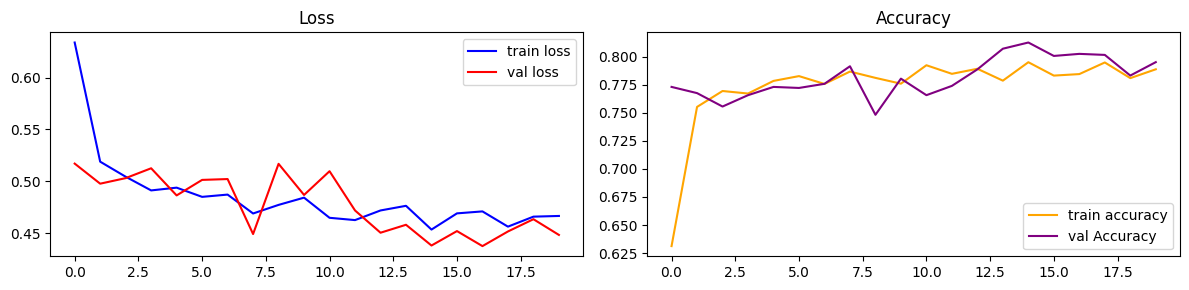

In [23]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
plt.plot(modhist.history['loss'], label='train loss', color= "blue")
plt.plot(modhist.history['val_loss'], label='val loss', color="red")
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(modhist.history['accuracy'], label='train accuracy', color= "orange")
plt.plot(modhist.history['val_accuracy'], label='val Accuracy', color= "purple")
plt.legend()
plt.title('Accuracy')

# plt.subplot(1, 2, 3)
# plt.plot(modhist.history['auc'], label='train AUC', color= "brown")
# plt.plot(modhist.history['val_auc'], label='val AUC', color= "green")
# plt.legend()
# plt.title('AUC')

plt.tight_layout()
plt.show()

We can see in the above graphs that the training loss and validation seems to stabilize at later epochs although we are only using 20 to reduce time for training. This is a good sign since we are likely not overfitting or underfitting.

Our accuracy for both trainig and validition also seem to be in line and follow ing the same trend and plateauing at the same time possiblity indicating our model has converged or getting close to converging.

## Hyperparameter tuning and building upon the Base Model

After testing out many different hyperparameter values including changes in batch size, several layers and filter sizes, different optimizers and learning rates, the below model architecture is an improvement over the intial base model. 

1. This model includes a dropout layer at each filter layer. This is important because it helps to reduce overfitting by randomly dropping neurons and by preventing neurons from relying to much on eachother, forcing network to learn more robust features of the data.
2. The dense layer (or fully connected layer) was also increased from 256 to 512 to model complex relationships between features and outputs. This also helps to capture no-linearity of the data with the activation functions.
3. Batch normalization layer is also included as a regularization techiniuq to improve the traiing speed and stability of the neural networks at each layer.

In [24]:
##Our Model architecture
##Convolutional layers
model2 = Sequential()

# # model2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape= (96, 96, 3)))
# # # model2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
# model.add(BatchNormalization())
# # model.add(AveragePooling2D(pool_size=(2, 2)))
# model2.add(MaxPool2D(pool_size=(2, 2)))
# model2.add(Dropout(0.1))

model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape= (96, 96, 3)))
# model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
# model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(AveragePooling2D(pool_size=(2, 2)))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))


model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
# model2.add(BatchNormalization())
# model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
# model2.add(AveragePooling2D(pool_size=(2, 2)))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))

model2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
# model2.add(BatchNormalization())
# model.add(AveragePooling2D(pool_size=(2, 2)))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))

##fully connected layers
model2.add(Flatten())
model2.add(Dense(units=512, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3, seed = rs))
model2.add(Dense(units=1, activation='sigmoid'))

##model compilation
##store different optimizers. Use for for project
# optimizers = SGD(learning_rate=0.01)
# optimizers = Nadam(learning_rate=0.0001)
optimizers = Adam(learning_rate=0.001)
# optimizers = Adagrad(learning_rate=0.0001)
model2.compile(optimizer=optimizers, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
##build model
# model2.build(input_shape=(batches, 96, 96, 3))
##View model summmary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 22, 22, 64)       

In [25]:
##Include callbacks for model fit
early_stop2 = EarlyStopping(monitor='val_loss', 
                           patience=10, 
                           restore_best_weights=True)
model_cp2 = ModelCheckpoint('bestmodel2.h5',
                           monitor= 'val_loss',
                           verbose= 1,
                           save_best_only=True)
reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=2, 
                              min_lr=0.0001)

##Include epoch steps and validation steps
spe = len(train_gen) // 8
valid_steps = len(valid_gen) // 8
##Model training
modhist2 = model2.fit_generator(
    train_gen,
    epochs=30,
    # batch_size= 8, ##batches,
    validation_data=valid_gen,
    callbacks=[early_stop2, model_cp2, 
               reduce_lr2],
    steps_per_epoch=spe,
    validation_steps=valid_steps
)

Epoch 1/30
557/557 [==============================] - ETA: 0s - loss: 0.5512 - accuracy: 0.7370
Epoch 1: val_loss improved from inf to 0.47835, saving model to bestmodel2.h5
557/557 [==============================] - 83s 146ms/step - loss: 0.5512 - accuracy: 0.7370 - val_loss: 0.4783 - val_accuracy: 0.7799 - lr: 0.0010
Epoch 2/30
557/557 [==============================] - ETA: 0s - loss: 0.4949 - accuracy: 0.7728
Epoch 2: val_loss did not improve from 0.47835
557/557 [==============================] - 98s 175ms/step - loss: 0.4949 - accuracy: 0.7728 - val_loss: 0.6438 - val_accuracy: 0.6949 - lr: 0.0010
Epoch 3/30
557/557 [==============================] - ETA: 0s - loss: 0.4790 - accuracy: 0.7810
Epoch 3: val_loss improved from 0.47835 to 0.46850, saving model to bestmodel2.h5
557/557 [==============================] - 95s 170ms/step - loss: 0.4790 - accuracy: 0.7810 - val_loss: 0.4685 - val_accuracy: 0.7887 - lr: 0.0010
Epoch 4/30
557/557 [==============================] - ETA: 0s - 

## Tuned Model Evaluation

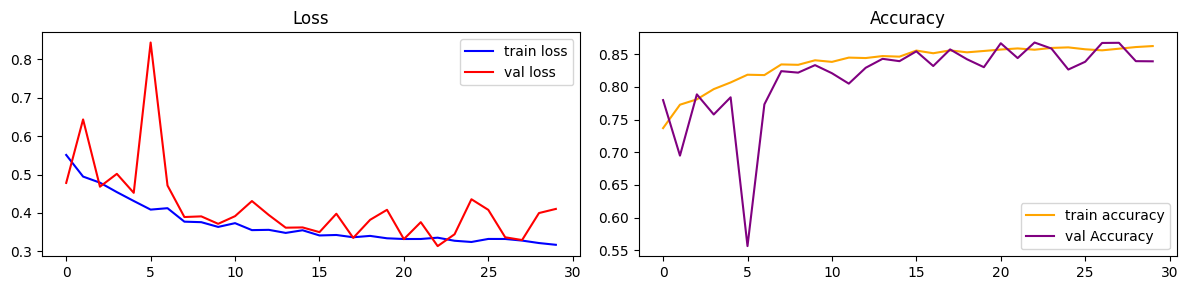

In [26]:
# Plotting training and validation loss and accuracy for model 2
plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
plt.plot(modhist2.history['loss'], label='train loss', color= "blue")
plt.plot(modhist2.history['val_loss'], label='val loss', color="red")
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(modhist2.history['accuracy'], label='train accuracy', color= "orange")
plt.plot(modhist2.history['val_accuracy'], label='val Accuracy', color= "purple")
plt.legend()
plt.title('Accuracy')

# plt.subplot(1, 2, 3)
# plt.plot(modhist.history['auc'], label='train AUC', color= "brown")
# plt.plot(modhist.history['val_auc'], label='val AUC', color= "green")
# plt.legend()
# plt.title('AUC')

plt.tight_layout()
plt.show()

We see above an improvement in our validation loss and accuracy. We see better convergence especially at later epochs.

In earlier iterations of the model when using large batches, training time for each epoch was upwards 7 minutes each. descreasing the epochs at each step for training and validation reduced the trainig time per epoch to aorunf 30 seconds each which is quite fast! Of course we may not get the best and most highly predictive model this way but the tradeoff is neccessary to be able to have time to run trainings for multiple different models.

Best model at epoch 23/30 was saved. Over the iterations the learning rate also updated, improving model performance.

## Predict on Test Dataset for Submission

Finally we will use our best model to predict the testing clasess: 0 for no cancer tumor detected, and 1 for cancerous tumor.

In [27]:
#create df to run the predictions on test set
test_df = pd.DataFrame({'id':os.listdir(test_path)})
test_df.head(7)

,id
0,00006537328c33e284c973d7b39d340809f7271b.tif
1,0000ec92553fda4ce39889f9226ace43cae3364e.tif
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3,000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4,000270442cc15af719583a8172c87cd2bd9c7746.tif
5,000309e669fa3b18fb0ed6a253a2850cce751a95.tif
6,000360e0d8358db520b5c7564ac70c5706a0beb0.tif


In [28]:
##{re[are datagenerator for test set. Do no ranomize/shuffle
gen_test = ImageDataGenerator(rescale=1./255)

test_gen = gen_test.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(96,96),
    batch_size=1,
    class_mode=None,
    shuffle=False)

Found 57458 validated image filenames.


In [29]:
##Load top modell=
# load_model('bestmodel.h5')
model_path= work_dir+'/bestmodel2.h5'
loadmod= load_model(model_path)

In [30]:
#run model to find predictions
preds = loadmod.predict(test_gen)

57458/57458 [==============================] - 160s 3ms/step


In [31]:
preds = np.transpose(preds)[0]
sub_df = pd.DataFrame({
    'id': test_df['id'].apply(lambda x: x.split('.')[0]),
    'label': (preds > 0.5).astype(int)})

##View submission dataframe
sub_df.head(7)

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0
5,000309e669fa3b18fb0ed6a253a2850cce751a95,0
6,000360e0d8358db520b5c7564ac70c5706a0beb0,0


In [32]:
#view test prediction counts
sub_df['label'].value_counts()

label
0    41532
1    15926
Name: count, dtype: int64

[Text(0, 0, 'Negatives'), Text(1, 0, 'Positives')]

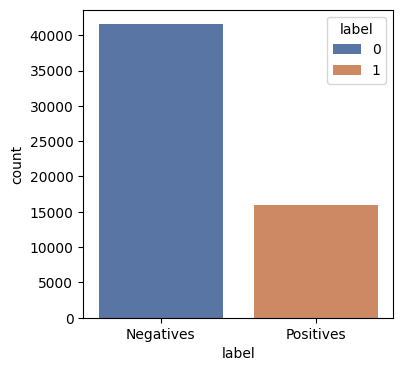

In [33]:
##View plot
plt.figure(figsize=(4, 4))
smplot = sns.countplot(x='label', hue='label', data=sub_df, palette="deep")
smplot.set_xticks([0, 1])
smplot.set_xticklabels(['Negatives','Positives'])


Now compare it to the sample submission. 

[Text(0, 0, 'Negatives'), Text(1, 0, 'Positives')]

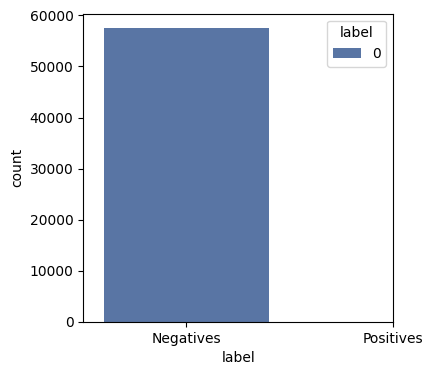

In [34]:
# sample_sub.label.values_count()
plt.figure(figsize=(4, 4))
sampp= sns.countplot(x='label', hue='label', data=sample_sub, palette="deep")
sampp.set_xticks([0, 1])
sampp.set_xticklabels(['Negatives','Positives'])

In [35]:
sample_sub.label.value_counts()

label
0    57458
Name: count, dtype: int64

So it looks like there are no postive labels in the submission example file. I wonder if our predictions should this file or this is just an example to show how many rows and columns our submission should have. Let's submit and check our final score.

In [36]:
#convert to csv and submit to get score
sub_df.to_csv('submission.csv', index=False)

Below is our Kaggle score

(-0.5, 1478.5, 175.5, -0.5)

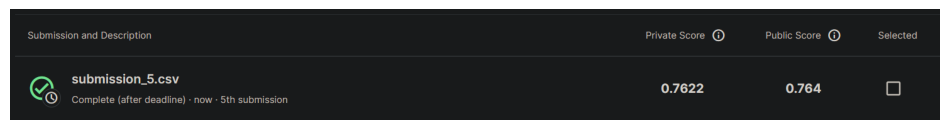

In [45]:
##Display kaggle score
kag_score_path= work_dir+"/Documents/MS DS coursework/Intro to Deep Learning/Week 3/hist_kaggle_Score_5.png"
ksi = Image.open(kag_score_path)

plt.figure(figsize=(12, 8))
plt.imshow(ksi)
plt.axis('off')

## Discussion/Conclusion

The first Convolutional Neural Network model worked quite well with a best epoch training accuracy of 0.7844 and validation accuracy of 0.8024 and loss of 0.4711 and 0.4377 respectively.

The second model worked even better to predict validation set. Up to 87% validation accuracy is not too bad considering our model is not exhaustive but tit benefited from adding normalization and dropout layers and allowing the model to train over more epochs.

Despite spending a large amount of time trying to improve the model, my final Kaggle competition public score is 0.764, indicating that there is much more room for improving upon the model! We can try furthur preprocessong and transforming the images in many different ways before training the data on the model. We can change the batch size also but this takes time and computational resources for training. 

Additionally, we can run a grid search and try to find the best optimizer, batch size, etc, but that would take extra computational resources. Steps to incease prediction accuracy on unseen data that doesn't involve hpertparameter tuning is in the data preprosessing step. Training testing sets and be split in different ways including rebalancing and changing the proportion split as well as not augmenting the orginial images before trainings. We can even compare our CNN model to other machine learning models as well such as gradient boost or randomforest models. In the end, the best case is finding the right balance between creating a model that does a good job generalizing to unseen data with a reasonable of time and effort.
